# Exploration du jeu de donnée Cardio_train avec l'algorithme Random Forest

L’algorithme des « forêts aléatoires » (ou Random Forest parfois aussi traduit par forêt d’arbres décisionnels) est un algorithme de classification qui réduit la variance des prévisions d’un arbre de décision seul, améliorant ainsi leurs performances. Pour cela, il combine de nombreux arbres de décisions dans une approche de type bagging.
Concrètement, chaque arbre de la forêt aléatoire est entrainé sur un sous ensemble aléatoire de données selon le principe du bagging, avec un sous ensemble aléatoire de features (caractéristiques variables des données) selon le principe des « projections aléatoires ».
Les prédictions sont ensuite moyennées lorsque les données sont quantitatives ou utilisés pour un vote pour des données qualitatives, dans le cas des arbres de classification.

*Loi des grands nombres* : 


## Aborder Random Forest 

*1er approche ***

In [1]:
import nltk
import pandas as pd
import re
import numpy as np
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import string


In [2]:
df = pd.read_csv('cardio_train.csv', sep=';', index_col=0)
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [3]:
df.shape

(70000, 12)

In [4]:
#Count the empty (NaN, NAN, na) values in each column
df.isna().sum()

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [5]:
df.describe ()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
import seaborn as sns
df ['cardio']. value_counts ()

0    35021
1    34979
Name: cardio, dtype: int64

/home/fatimam/anaconda3/envs/my_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='cardio', ylabel='count'>

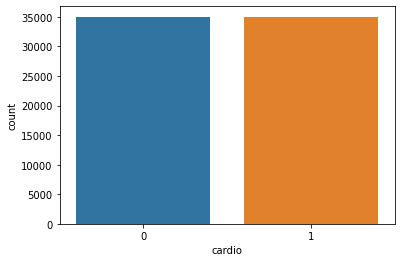

In [7]:
sns.countplot (df ['cardio'])

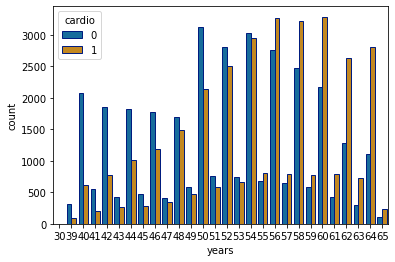

In [8]:
# Let's look at  the number of people with a Cardio Vascular Disease that exceed
#the number of people without a Cardio Vascular Disease?
#Create a years column
df['years'] = ( df['age'] / 365).round(0)   #Get the years by dividing the age in days by 365
df["years"] = pd.to_numeric(df["years"],downcast='integer') # Convert years to an integer
#Visualize the data
#colorblind palette for colorblindness
sns.countplot(x='years', hue='cardio', data = df, palette="colorblind", edgecolor=sns.color_palette("dark", n_colors = 1));

In [12]:
df.corr()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,years
age,1.000000,-0.022811,-0.081515,0.053684,0.020764,0.017647,0.154424,0.098703,-0.047633,-0.029723,-0.009927,0.238159,0.999090
gender,-0.022811,1.000000,0.499033,0.155406,0.006005,0.015254,-0.035821,-0.020491,0.338135,0.170966,0.005866,0.008109,-0.023017
height,-0.081515,0.499033,1.000000,0.290968,0.005488,0.006150,-0.050226,-0.018595,0.187989,0.094419,-0.006570,-0.010821,-0.081456
weight,0.053684,0.155406,0.290968,1.000000,0.030702,0.043710,0.141768,0.106857,0.067780,0.067113,-0.016867,0.181660,0.053661
ap_hi,0.020764,0.006005,0.005488,0.030702,1.000000,0.016086,0.023778,0.011841,-0.000922,0.001408,-0.000033,0.054475,0.020793
ap_lo,0.017647,0.015254,0.006150,0.043710,0.016086,1.000000,0.024019,0.010806,0.005186,0.010601,0.004780,0.065719,0.017754
cholesterol,0.154424,-0.035821,-0.050226,0.141768,0.023778,0.024019,1.000000,0.451578,0.010354,0.035760,0.009911,0.221147,0.154386
gluc,0.098703,-0.020491,-0.018595,0.106857,0.011841,0.010806,0.451578,1.000000,-0.004756,0.011246,-0.006770,0.089307,0.098596
smoke,-0.047633,0.338135,0.187989,0.067780,-0.000922,0.005186,0.010354,-0.004756,1.000000,0.340094,0.025858,-0.015486,-0.047884
alco,-0.029723,0.170966,0.094419,0.067113,0.001408,0.010601,0.035760,0.011246,0.340094,1.000000,0.025476,-0.007330,-0.029918


In [16]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


<AxesSubplot:>

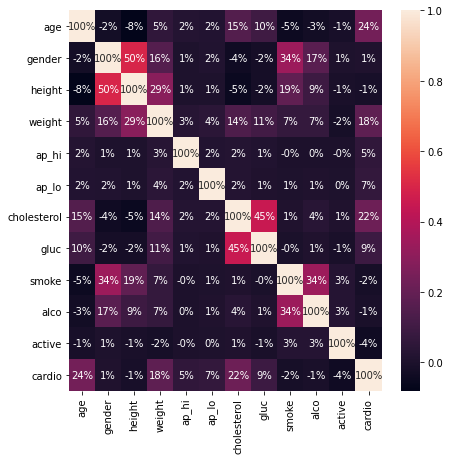

In [17]:
#Visualize the correlation
import matplotlib.pyplot as plt
plt.figure(figsize=(7,7))  #7in by 7in
sns.heatmap(df.corr(), annot=True, fmt='.0%')

## approche 1

In [26]:
#Split the data into feature data and target data
X = df.iloc[:, :-1].values
Y = df.iloc[:, -1].values

In [27]:
#Split the data again, into 75% training data set and 25% testing data set
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.25, random_state = 1)

In [28]:
#Feature Scaling
#Scale the values in the data to be values between 0 and 1 inclusive
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [29]:
# Use Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 1)
forest.fit(X_train, Y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=1)

In [30]:
#Test the models accuracy on the trainingg data set
model = forest
model.score(X_train, Y_train)

0.979904761904762

In [31]:
#Test the models accuracy on the test data set
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, model.predict(X_test))
TN = cm[0][0]
TP = cm[1][1]
FN = cm[1][0]
FP = cm[0][1]
#Print the confusion matrix
print(cm)
#Print the models accuracy on the test data
print('Model Test Accuracy = {}'. format( (TP + TN)/ (TP +TN + FN + FP)  ) )


[[6487 2122]
 [3093 5798]]
Model Test Accuracy = 0.702


## approche 2

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(df.drop('cardio', axis=1), df['cardio'], test_size =0.3, random_state=2019)

In [33]:
rf = RandomForestClassifier(n_estimators=100, random_state=2019)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_valid)
from sklearn.metrics import accuracy_score
print(accuracy_score(y_valid, y_pred))


0.7155714285714285


Feature ranking:
1 age 0.3062576606097183
2 weight 0.17365485187064147
3 ap_hi 0.17140090916033016
4 height 0.15482192177844792
5 ap_lo 0.09129114421301521
6 cholesterol 0.04014111172468464
7 gluc 0.017200286456063
8 gender 0.016268097358439267
9 active 0.012558712395089135
10 smoke 0.008680266460330413
11 alco 0.007725037973240669


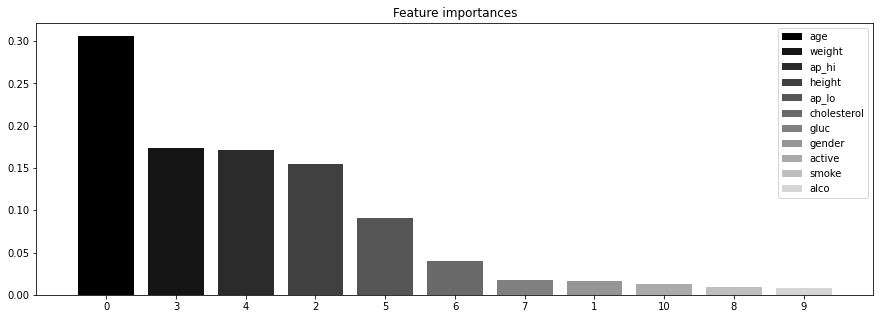

In [36]:
features = dict(zip(range(len(df.columns)-1), df.columns[:-1]))

importances = rf.feature_importances_

indices = np.argsort(importances)[::-1]

num_to_plot = max(10, len(df.columns[:-1]))
feature_indices = [ind for ind in indices[:num_to_plot]]


print("Feature ranking:")

for f in range(num_to_plot):
    print(f+1, features[feature_indices[f]], importances[indices[f]])

plt.figure(figsize=(15,5))
plt.title("Feature importances")
bars = plt.bar(range(num_to_plot), 
               importances[indices[:num_to_plot]],
               color=([str(i/float(num_to_plot+1)) for i in range(num_to_plot)]),
               align="center")
ticks = plt.xticks(range(num_to_plot), 
                   feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u''.join(features[i]) for i in feature_indices]);

*approche 2*